In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import utils

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
varname='pr'
varlev='sfc'
dataset='CPC-PRECIP'

basepath='/shared/subx/'
modelpath=basepath+'hindcast/'+varname+varlev+'/daily/anoms/'
verifpath=basepath+'verif/prsfc/daily/anoms/'+dataset+'/'
file_stub='_????*.anoms.daily'

gregions=['ENA','CNA','WNA']
gregnums=[5,6,7]

smoothlist=[1,7,14,21,28,30]
smoothcolors=['k','r','b','g','y','c']

In [4]:
groups=['ECCC','ESRL','NCEP','RSMAS',
        'EMC','GMAO','NRL','CESM','CESM']

models=['GEM','FIMr1p1','CFSv2','CCSM4',
       'GEFS','GEOS_V2p1','NESM','46LCESM1',
       '30LCESM1']

In [5]:
ds_gmask=utils.getGiorgiMask()

In [6]:
ds_giorgi_verif=utils.getSubxVerifGiorgi(verifpath,dataset,varname,
                                         varlev,file_stub,ds_gmask,
                                         gregions,gregnums)

In makeGiorgi
<xarray.Dataset>
Dimensions:  (ic: 682, lat: 181, lon: 360, time: 45)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 35 36 37 38 39 40 41 42 43 44
  * ic       (ic) datetime64[ns] 1999-01-01 1999-01-02 ... 2020-01-30 2020-01-31
Data variables:
    pr       (ic, time, lat, lon) float32 dask.array<chunksize=(1, 45, 181, 360), meta=np.ndarray>
Attributes:
    title:         SubX Verification Anomalies
    long_title:    SubX Verification Anomalies
    comments:      SubX project http://cola.gmu.edu/~kpegion/subx/
    institution:   IRI
    source:        SubX IRI
    CreationDate:  2018/07/01 19:37:54
    CreatedBy:     kpegion
    MatlabSource:  


In [7]:
all_list=[]

for i,(group,model) in enumerate(zip(groups,models)):

    print(group,model)
    
    # Get Giorgi Regions for SubX Models
    ds_giorgi_model=utils.getSubXModelGiorgi(modelpath,model,
                                             group,varname,varlev,
                                             file_stub,ds_gmask,
                                             gregions,gregnums)
    # Calc sliding skill
    skill_tmp=utils.calcSkillSliding(ds_giorgi_model,
                                     ds_giorgi_verif,
                                     gregions,
                                     smoothlist)
    
    # Combine the sliding skill together into a dimension
    tmp=xr.combine_nested(skill_tmp,concat_dim='swin').compute()
    
    # Add the sliding window skill to the giant list for this model
    all_list.append(tmp)

ECCC GEM
In makeGiorgi
<xarray.Dataset>
Dimensions:  (ic: 496, lat: 181, lon: 360, time: 32)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * ic       (ic) datetime64[ns] 1999-01-01 1999-01-02 ... 2014-01-30 2014-01-31
Data variables:
    pr       (ic, time, lat, lon) float32 dask.array<chunksize=(1, 32, 181, 360), meta=np.ndarray>
Attributes:
    title:         SubX Anomalies
    long_title:    SubX Anomalies
    comments:      SubX project http://cola.gmu.edu/~kpegion/subx/
    institution:   IRI
    source:        SubX IRI
    CreationDate:  2018/07/13 05:18:40
    CreatedBy:     kpegion
    MatlabSource:  


#### Put all the models together

In [8]:
all_models=xr.combine_nested(all_list,concat_dim='model')
all_models=all_models.persist()
all_models['model']=models
all_models['swin']=smoothlist
all_models

<xarray.Dataset>
Dimensions:  (model: 1, swin: 6, time: 32)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * model    (model) <U3 'GEM'
  * swin     (swin) int64 1 7 14 21 28 30
Data variables:
    ENA      (model, swin, time) float64 0.7575 0.8461 0.8084 ... nan nan nan

#### Write data

In [9]:
all_models.to_netcdf('all_models_acc_CONUS_giorgi.1-12.nc')

#### Plot

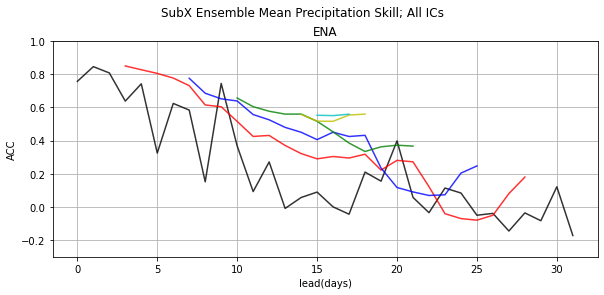

In [12]:
figname='all_models_acc_CONUS_giorgi.1-12.png'
utils.plotSlidingCorrs(all_models,gregions,smoothcolors,
                       smoothlist,figname)